In [2]:
# Import External Packages
from scipy.optimize import minimize # finding optimal params in models
import os                           # operating system tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import matplotlib.pyplot as plt     # plotting
import datetime

# Importing Custom Functions
import reinforcementLearningFns as rlf
import plotFns as psyplt
import helperFns as mf

# Setting Seed for Reproducibility
np.random.seed(2021)

curPath = os.path.abspath(os.getcwd())

In [ ]:
# In this notebook, we will simulate choice data using the Choice-History model, and fit that 
# data with our model in order to demonstrate that we can recover the original parameters. Then, 
# we will apply our model to real behavioral data and compare simulations using those parameters
# with the actual behavior.

Starting Learning Simulation


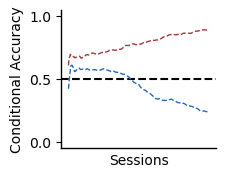

In [11]:
## Okay, let's use our reinforcement learning model to simulate choice data. We need to pick some parameters!

model_params_init = {
    'N': 10000, # Number of trials
    'alpha': 0.003, # Learning rate
    'beta': .05, # Choice-History parameter
    'bias': 0.05, # Overall bias, signed towards "High frequency"
    'init_Q': [0.05,-0.05], # Initial value bias. This bias indicates an initial value bias towards "High frequency"
    'max_num_cts': 3, # Presence of correction trials in simulation
}

# Simulate choices from parameters
sim = rlf.simulateFromParameters(model_params_init, R = 1)

# Plot category-conditional accuracy traces of the simulated learning trajectory
fig, ax = psyplt.plotFitSimulations(sim, reps = 1, nPoints = 400, smoothF = 5, smooth2 = 5)
plt.show()

In [14]:
## Now, let's fit our model to the simulated data to see if we can recover the underlying parameters!

ns = 2 # For demonstration, will run twice- usually would run from different parameter starting points.
# There are 4 parameters, and each run takes ~1-2 minutes. Therefore, ns = 1 ~2 minutes, ns = 2 ~ 20 minutes.

alpha = 0
beta = 0
bias = 0
iQ = [0, 0]

model_params = {
    'N': np.nan,
    'alpha': alpha,
    'beta': 1000,
    'bias': 0,
    'init_Q': iQ,
    'max_num_cts': 3,
}

#initialize dataframe to store results
df = pd.DataFrame(index=range(0,2), columns=['id','bias','alpha','beta','init_Q','nLL'])

nParams = 4

bias_grid = np.linspace(-0.15, 0.15, ns)
alpha_grid= np.linspace(.0003,.01,ns)
beta_grid = np.linspace(.001,.5,ns)
init_q_grid = np.linspace(-0.2,0.2,ns)

bias_range = (-0.4, 0.4)
alpha_range = (.00001,.1)
beta_range = (.0001,20)
init_q_range = (-1, 1)

individualFits = {}

dataframefull = ()

subj_choice = sim['choice']
stim_cat = sim['stim_stored'][:,1]

# gradient descent to minimize neg LL
res_nll = np.inf # set initial neg LL to be inf

df_temp = pd.DataFrame(index=range(0,ns**nParams), columns=['bias','alpha','beta','init_Q','nLL','N','D'])

ii = 0
# guess several different starting points for alpha, beta, init_q, bias...
for bias_guess in bias_grid:
    for alpha_guess in alpha_grid:
        for beta_guess in beta_grid:
            for init_q_guess in init_q_grid:
                # guesses for bias, alpha, beta, init will change on each loop
                init_guess = (bias_guess, alpha_guess, beta_guess, init_q_guess)

                # minimize neg LL
                result = minimize(rlf.fitLearning, 
                                    init_guess, 
                                    (model_params, subj_choice, stim_cat), 
                                    bounds = (bias_range, alpha_range, beta_range, init_q_range))
                
                # if current negLL is smaller than the last negLL,
                # then store current data

                df_temp.at[ii, 'bias'] = result.x[0]
                df_temp.at[ii, 'alpha'] = result.x[1]
                df_temp.at[ii, 'beta'] = result.x[2]
                df_temp.at[ii, 'init_Q'] = result.x[3]
                df_temp.at[ii, 'nLL'] = result.fun
                df_temp.at[ii, 'N'] = len(subj_choice)
                df_temp.at[ii, 'D'] = len(init_guess)
                ii += 1
                    
df_temp = df_temp.sort_values(by = ['nLL'])
df_temp = df_temp.reset_index()
df_disp = df_temp.copy()
df_disp = df_disp.head(1)
df_disp['index'] = 'SIM RESULTS'

df_disp.loc[1,'index'] = 'INIT PARAMS'
df_disp.loc[1,'bias'] = model_params_init['bias']
df_disp.loc[1,'alpha'] = model_params_init['alpha']
df_disp.loc[1,'beta'] = model_params_init['beta']
df_disp.loc[1,'init_Q'] = model_params_init['init_Q'][0]

print(df_disp[['index','bias','alpha','beta','init_Q']])


         index      bias     alpha      beta    init_Q
0  SIM RESULTS  0.053819  0.002479  0.063354  0.032471
1  INIT PARAMS      0.05     0.003      0.05      0.05


In [88]:
# We can see that the model is able to retrieve the original parameters well. Now, we will apply the model to real behavioral data.

IDs = ('JC059',)

dataBase =  os.path.abspath(os.path.join(curPath,"data/Trajectories/with_bias_learning/"))

alpha = 0 # "Rate", how much the prediction error updates the weights
beta = 0 # Generalization decay constant: how much does the "update" affect both stimulus associations vs. being stimulus-specific? High = more stimulus-specific
bias = 0 # Initial starting bias (towards high), is added to the weight*stimulus before the logistic function.

iQ = [0, 0]

model_params = {
    'N': np.nan,
    'alpha': alpha,
    'beta': 1000,
    'bias': 0,
    'init_Q': iQ,
    'max_num_cts': 3,
}

#initialize dataframe to store results
df = pd.DataFrame(index=range(0,len(IDs)), columns=['id','bias','alpha','beta','init_Q','nLL'])

nParams = 4

ns = 1

bias_grid = np.linspace(-0.15, 0.15, ns)
alpha_grid= np.linspace(.0003,.01,ns)
beta_grid = np.linspace(.001,.5,ns)
init_q_grid = np.linspace(-0.2,0.2,ns)

bias_range = (-0.4, 0.4)
alpha_range = (.00001,.1)
beta_range = (.0001,20)
init_q_range = (-1, 1)

individualFits = {}

dataframefull = ()

for index, ID in enumerate(IDs):

    loaded_dict = mf.loadSavedFits(ID, dataBase, ending = '_trainingDataBias')
    subj_choice = np.array(loaded_dict['y'])
    stim_cat = np.array(loaded_dict['answer']) - 1

    # gradient descent to minimize neg LL
    res_nll = np.inf # set initial neg LL to be inf
    
    df_temp = pd.DataFrame(index=range(0,ns**nParams), columns=['bias','alpha','beta','init_Q','nLL','N','D'])

    ii = 0
    # guess several different starting points for alpha, beta, init_q, bias...
    for bias_guess in bias_grid:
        for alpha_guess in alpha_grid:
            for beta_guess in beta_grid:
                for init_q_guess in init_q_grid:
                    # guesses for bias, alpha, beta, init will change on each loop
                    init_guess = (bias_guess, alpha_guess, beta_guess, init_q_guess)

                    # minimize neg LL
                    result = minimize(rlf.fitLearning, 
                                        init_guess, 
                                        (model_params, subj_choice, stim_cat), 
                                        bounds = (bias_range, alpha_range, beta_range, init_q_range))
                    
                    # if current negLL is smaller than the last negLL,
                    # then store current data

                    df_temp.at[ii, 'bias'] = result.x[0]
                    df_temp.at[ii, 'alpha'] = result.x[1]
                    df_temp.at[ii, 'beta'] = result.x[2]
                    df_temp.at[ii, 'init_Q'] = result.x[3]
                    df_temp.at[ii, 'nLL'] = result.fun
                    df_temp.at[ii, 'N'] = len(subj_choice)
                    df_temp.at[ii, 'D'] = len(init_guess)
                    ii += 1

                    if result.fun < res_nll and result.success:
                        res_nll = result.fun
                        param_fits = result.x
                    
    df_temp = df_temp.sort_values(by = ['nLL'])
    df_temp = df_temp.reset_index()

    df_temp['index'] = ID
    if len(dataframefull) == 0:
        dataframefull = df_temp
    else:
        dataframefull = pd.concat([dataframefull, df_temp])

    # also, compute BIC
    BIC = len(init_guess) * np.log(len(subj_choice)) + 2*res_nll

    #store in dataframe
    df.at[index, 'id'] = ID
    df.at[index, 'bias'] = param_fits[0]
    df.at[index, 'alpha'] = param_fits[1]
    df.at[index, 'beta'] = param_fits[2]
    df.at[index, 'init_Q'] = param_fits[3]
    df.at[index, 'nLL'] = res_nll
    df.at[index, 'BIC'] = BIC

    today = datetime.datetime.now()
    date_time = today.strftime("%y%m%d")

    tmp = 'new_data/' + date_time + '_RL_Data/'
   
    if not os.path.isdir(tmp):
        os.makedirs(tmp)

    saveName = '{}param_{}.csv'.format(nParams,date_time)

    dataframefull.to_csv(tmp + 'fits_' + saveName)
    df.to_csv(tmp + 'model_' + saveName)

    print(fr'subject {ID}: bias={param_fits[0]:.4f}, alpha={param_fits[1]:.4f}, beta={param_fits[2]:.4f}, init_Q = {param_fits[3]:.4f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')

subject JC059: bias=-0.1229, alpha=0.0013, beta=0.3554, init_Q = -0.4963; negLL=2547.83; BIC=5129.27


In [4]:
# We can interpret these parameters directly. According to the model, the mouse has an overall tendency to 
# prefer the low category. The beta term exp(-.35) = 0.7 tells us that 70% of the updating information from
# each trial is assigned in a stimulus-independent manner. The mouse has an initial "value bias" towards the
# high category.

0.7046880897187134

Starting Learning Simulation


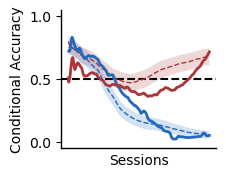

In [91]:
# Now that we have the best-fitting model parameters for JC059, we can simulate sessions with these parameters 
# and compare them to the actual behavior.

ID = 'JC059'

mfN = 4
reps = 50

smoothF = 5
nPoints = 400
smooth2 = 5

sim = rlf.simulateFromFit(ID, mfN, reps, folder = 'new_data')
fig, ax = psyplt.plotFitSimulations(sim, reps, nPoints, smoothF, smooth2)
plt.show()

In [ ]:
# For JC059, we can see that, qualitatively, the trajectories of the actual behavioral conditional accuracies and those of the model have a lot in common!